In [124]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns 

In [125]:
df = pd.read_parquet('../data/cleaned/electricity.parquet')
df = df[['index', 'MT_124']]
df.columns

Index(['index', 'MT_124'], dtype='object')

In [132]:
df['index'] = pd.to_datetime(df['index'])
df.columns

Index(['index', 'MT_124'], dtype='object')

Implement 24h differencing 

## Stationarity Analysis

In [127]:
from statsmodels.tsa.stattools import adfuller, kpss
import warnings
warnings.filterwarnings('ignore')

def stationarity_analysis(df, dataset_name, column_name = None):
    """
    column_name: specify the column to analyze, default is 'Close'
    Perform ADF and KPSS tests for stationarity analysis
    """
    data = df['Close'] if column_name is None else df[column_name]
    
    data.dropna(inplace=True)  # Drop NaN values for accurate testing
    
    print(f"\n{'='*50}")
    print(f"STATIONARITY ANALYSIS: {dataset_name.upper()}")
    print(f"{'='*50}")
    
    # ADF Test
    print("\n--- AUGMENTED DICKEY-FULLER TEST ---")
    adf_result = adfuller(data, autolag='AIC')
    print(f"ADF Statistic: {adf_result[0]:.6f}")
    print(f"p-value: {adf_result[1]:.6f}")
    print("Critical Values:")
    for key, value in adf_result[4].items():
        print(f"\t{key}: {value:.6f}")
    
    if adf_result[1] <= 0.05:
        print("ADF Result: STATIONARY (Reject null hypothesis)")
    else:
        print("ADF Result: NON-STATIONARY (Fail to reject null hypothesis)")
    
    # KPSS Test
    print("\n--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---")
    kpss_result = kpss(data, regression='c', nlags='auto')
    print(f"KPSS Statistic: {kpss_result[0]:.6f}")
    print(f"p-value: {kpss_result[1]:.6f}")
    print("Critical Values:")
    for key, value in kpss_result[3].items():
        print(f"\t{key}: {value:.6f}")
    
    if kpss_result[1] <= 0.05:
        print("KPSS Result: NON-STATIONARY (Reject null hypothesis)")
    else:
        print("KPSS Result: STATIONARY (Fail to reject null hypothesis)")
    
    # Combined interpretation
    print("\n--- COMBINED INTERPRETATION ---")
    adf_stationary = adf_result[1] <= 0.05
    kpss_stationary = kpss_result[1] > 0.05
    
    if adf_stationary and kpss_stationary:
        print("CONCLUSION: Series is STATIONARY")
    elif not adf_stationary and not kpss_stationary:
        print("CONCLUSION: Series is NON-STATIONARY")
    else:
        print("CONCLUSION: Results are INCONCLUSIVE - further investigation needed")

stationarity_analysis(df=df, dataset_name="Elec_Raws", column_name='MT_124')


STATIONARITY ANALYSIS: ELEC_RAWS

--- AUGMENTED DICKEY-FULLER TEST ---
ADF Statistic: -39.209344
p-value: 0.000000
Critical Values:
	1%: -3.430397
	5%: -2.861561
	10%: -2.566781
ADF Result: STATIONARY (Reject null hypothesis)

--- KWIATKOWSKI-PHILLIPS-SCHMIDT-SHIN TEST ---
KPSS Statistic: 1.865102
p-value: 0.010000
Critical Values:
	10%: 0.347000
	5%: 0.463000
	2.5%: 0.574000
	1%: 0.739000
KPSS Result: NON-STATIONARY (Reject null hypothesis)

--- COMBINED INTERPRETATION ---
CONCLUSION: Results are INCONCLUSIVE - further investigation needed


In [128]:
# # correlation plot of all the features in the dataframe
# plt.figure(figsize=(10, 8))
# sns.heatmap(df.drop(columns=['index']).corr(), annot=True, fmt=".4f", cmap='coolwarm', cbar=True)
# plt.title('Correlation Matrix of Customers\' Electricity Consumption')
# plt.show()

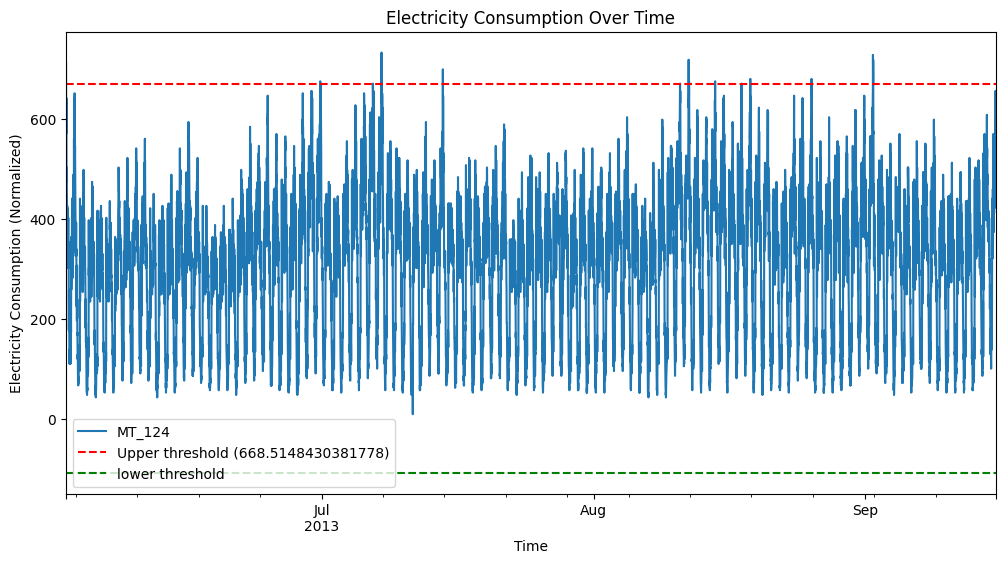

In [129]:
df[84750:94929].plot(x='index', y='MT_124', title='Electricity Consumption Over Time', figsize=(12, 6))
# draw two horisontal lines at y=0.2 and y=0.8
STD = 3
df['MT_124'].mean(), df['MT_124'].std()
UTH = df['MT_124'].mean() + STD*df['MT_124'].std()
LTH = df['MT_124'].mean() - STD*df['MT_124'].std()
plt.axhline(y=df['MT_124'].mean() + STD*df['MT_124'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
plt.axhline(y=df['MT_124'].mean() - STD*df['MT_124'].std(), color='g', linestyle='--', label='lower threshold')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (Normalized)')
plt.legend()
plt.show()

In [130]:
df['MT_124'].mean(), df['MT_124'].std()

# count the number of outliers in the MT_124 column
outliers = df[(df['MT_124'] > df['MT_124'].mean() + 3*df['MT_124'].std()) | (df['MT_124'] < df['MT_124'].mean() - 3*df['MT_124'].std())]
print(len(outliers))
outliers

mean_lr = df['MT_124'].mean()
std_lr = df['MT_124'].std()
CLAMP_STD = 3

upper = mean_lr + CLAMP_STD * std_lr
lower = mean_lr - CLAMP_STD * std_lr

df['MT_124'] = np.where(df['MT_124'] > upper, upper,
                        np.where(df['MT_124'] < lower, lower, df['MT_124']))


# count the number of outliers in the MT_124 column
outliers = df[(df['MT_124'] > UTH) | (df['MT_124'] < LTH)]
len(outliers)
# outliers


53


0

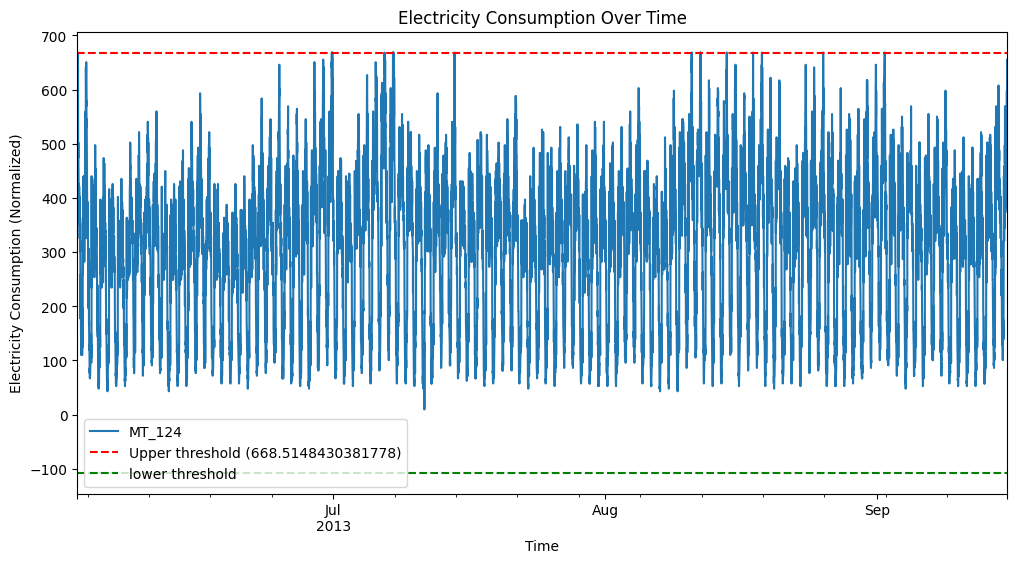

In [131]:
df[84750:94929].plot(x='index', y='MT_124', title='Electricity Consumption Over Time', figsize=(12, 6))
# draw two horisontal lines at y=0.2 and y=0.8
STD = 3
df['MT_124'].mean(), df['MT_124'].std()
plt.axhline(y=df['MT_124'].mean() + STD*df['MT_124'].std(), color='r', linestyle='--', label=f'Upper threshold ({UTH})')
plt.axhline(y=df['MT_124'].mean() - STD*df['MT_124'].std(), color='g', linestyle='--', label='lower threshold')
plt.xlabel('Time')
plt.ylabel('Electricity Consumption (Normalized)')
plt.legend()
plt.show()